In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
words = open('/Users/raghx/Desktop/Neural Networks/names.txt','r',).read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_length = len(itos)
      

In [4]:
#Dataset Creation
def build_dataset(words):
    X = []
    Y = []
    block_size = 3
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y


In [5]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_tr,Y_tr = build_dataset(words[:n1])
X_val,Y_val = build_dataset(words[n1:n2])
X_test,Y_test = build_dataset(words[n2:])


In [7]:
n_embedding = 10
n_hidden = 200
block_size = 3 
g = torch.Generator().manual_seed(3332321)
C = torch.randn(((vocab_length,n_embedding)),generator=g)
w1 = torch.randn((n_embedding * block_size,n_hidden),generator=g) * ((2)/((n_embedding * block_size) ** 0.5))       # kamimi init for relu
# b1 = torch.randn(n_hidden,generator=g) * 0.001    # bias not used because we have batch normal layer's bias(bn_bias)
w2 = torch.randn((n_hidden,vocab_length),generator=g) * 0.01
b2 = torch.randn(vocab_length,generator=g) * 0
bn_gain = torch.ones(1,n_hidden)
bn_bias = torch.zeros(1,n_hidden)
bn_running_mean = torch.zeros(1,n_hidden)
bn_running_std = torch.ones(1,n_hidden)
params = [C,w1,w2,b2,bn_bias,bn_gain]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

12097


In [10]:
#forward pass
batch_size = 32 
max_steps = 30000
loss_i =[]
momentum = 0.99
for k in range(max_steps):
    ikx = torch.randint(0,X_tr.shape[0],(batch_size,),generator=g)
    embd = C[X_tr[ikx]]
    a_pre_activation = embd.view(embd.shape[0],-1) @ w1 #b1
#batch normalization    
    meani =  a_pre_activation.mean(0,keepdim=True)
    stdi = a_pre_activation.std(0,keepdim=True)
    a_pre_activation = bn_gain * ((a_pre_activation - meani)/(0.00001 + stdi )) + bn_bias    
    with torch.no_grad():
        bn_running_mean = momentum * bn_running_mean + 0.01 * meani
        bn_running_std = momentum * bn_running_std + 0.01 * stdi
#activations for hidden layer
    a = torch.relu(a_pre_activation)
#Output layer    
    logits = a @ w2 + b2
    loss = F.cross_entropy(logits,Y_tr[ikx])
#backward pass
    for p in params:
        p.grad = None
    loss.backward()
    lr = 0.001 if k > 10000 else 0.1
    for p in params:
        p.data += -lr * p.grad

    if k % 5000 == 0:
        print(f'{k}/{max_steps}:{loss.item()}')

    loss_i.append(loss.item())

0/30000:3.3208882808685303
5000/30000:2.5905637741088867
10000/30000:2.404512882232666
15000/30000:1.837352991104126
20000/30000:1.9155668020248413
25000/30000:2.0837790966033936


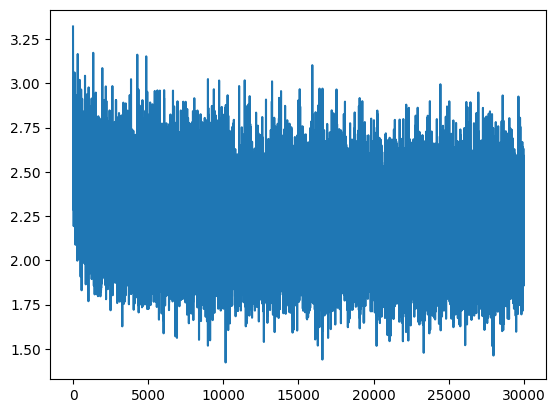

In [11]:
plt.plot(loss_i)

In [12]:
#Inference 
@torch.no_grad()
def Split_loss(split):
    x,y = {
        'train': (X_tr,Y_tr),
        'val': (X_val,Y_val),
        'test': (X_test,Y_test)
    }[split]
    embd = C[x]
    a_pre_activation = embd.view(embd.shape[0],-1) @ w1 # + b1
    a_pre_activation = bn_gain * ((a_pre_activation - bn_running_mean)/(0.00001 + bn_running_std)) + bn_bias
    a = torch.relu(a_pre_activation)
    logits = a @ w2 + b2
    loss = F.cross_entropy(logits,y)
    return loss.item()

print("Training loss",Split_loss('train'))
print("Validation loss",Split_loss('val'))

Training loss 2.147233247756958
Validation loss 2.4052977561950684


In [ ]:
# -> Original initial loss
# Training loss 25.325109481811523
# Validation loss 25.109655380249023

# -> after fixing initial loss by reducing bias and weights value for reducing output logits value
# Training loss 3.897186756134033
# Validation loss 3.88931941986084

# -> fixing tanh problem by reducing b1 and w1
# Training loss 2.1027655601501465
# Validation loss 2.3686301708221436

In [13]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_length, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_length, bias=False), BatchNorm1d(vocab_length),
]
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


        

        
        


47024


In [14]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_tr[ix], Y_tr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 3.3163


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.06%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.62%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.06%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.00%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 2.09%


Text(0.5, 1.0, 'activation distribution')

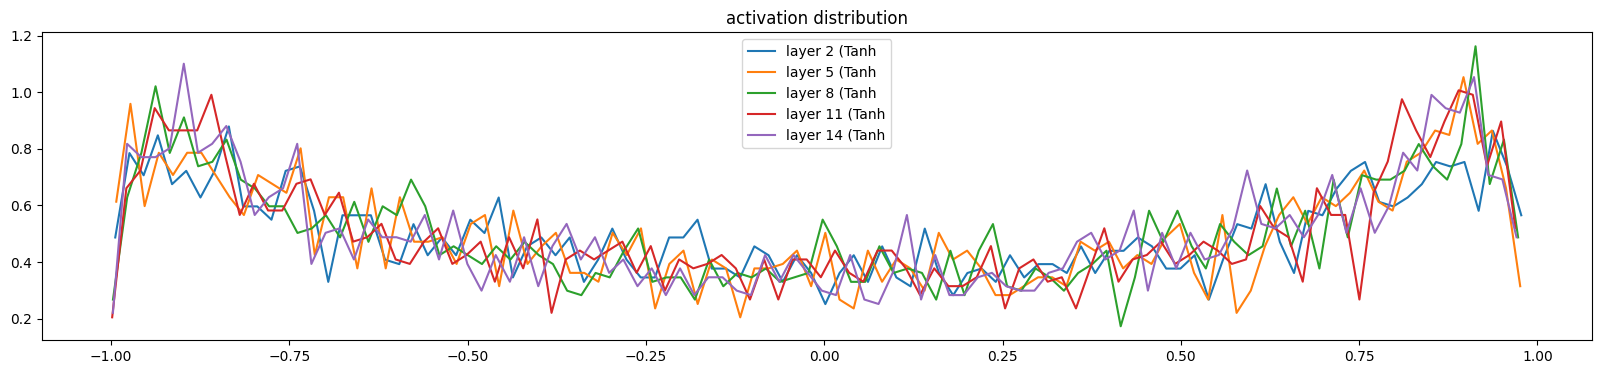

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot drawn
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.146955e-03
layer 5 (      Tanh): mean +0.000000, std 2.541767e-03
layer 8 (      Tanh): mean +0.000000, std 2.261609e-03
layer 11 (      Tanh): mean -0.000000, std 2.049852e-03
layer 14 (      Tanh): mean +0.000000, std 2.017093e-03


Text(0.5, 1.0, 'gradient distribution')

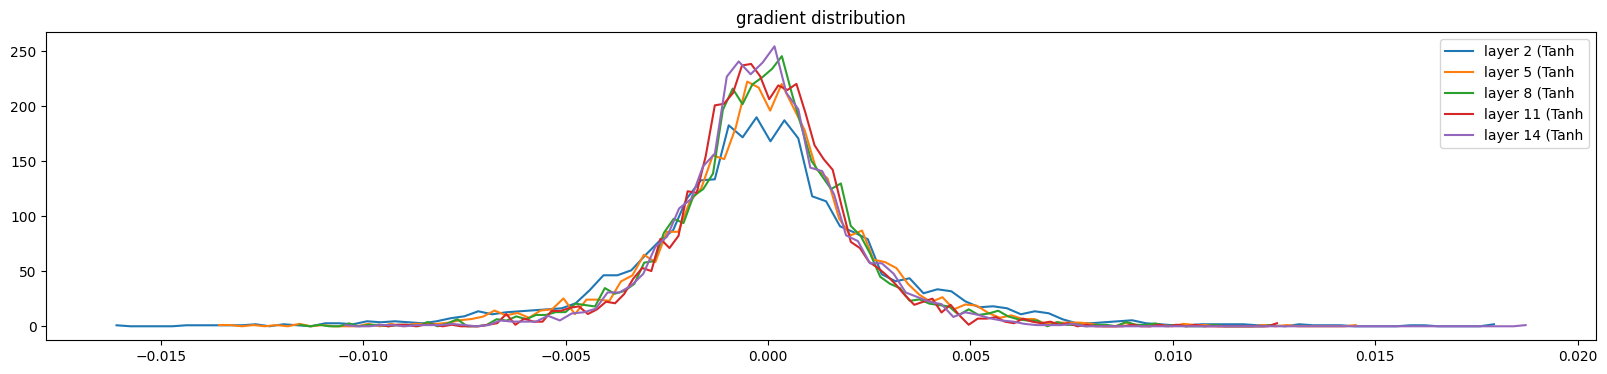

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plott
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.846103e-03 | grad:data ratio 9.836276e-03
weight  (30, 100) | mean +0.000115 | std 1.268368e-02 | grad:data ratio 6.694607e-02
weight (100, 100) | mean -0.000087 | std 9.106186e-03 | grad:data ratio 8.886336e-02
weight (100, 100) | mean +0.000089 | std 7.369707e-03 | grad:data ratio 7.178764e-02
weight (100, 100) | mean -0.000063 | std 6.585184e-03 | grad:data ratio 6.460540e-02
weight (100, 100) | mean -0.000079 | std 5.976033e-03 | grad:data ratio 5.870432e-02
weight  (100, 27) | mean +0.000009 | std 1.119276e-02 | grad:data ratio 1.073381e-01


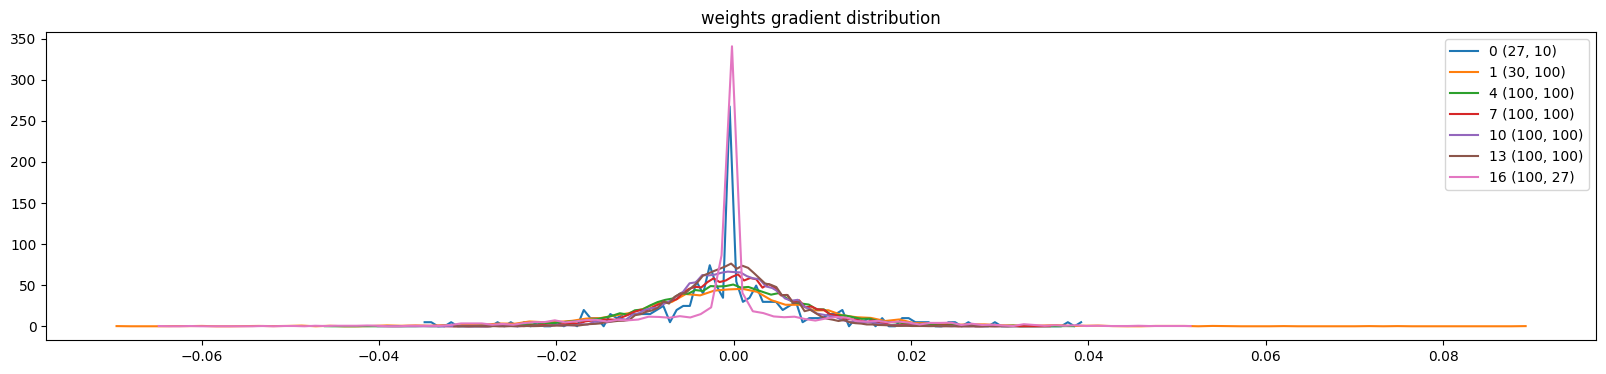

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


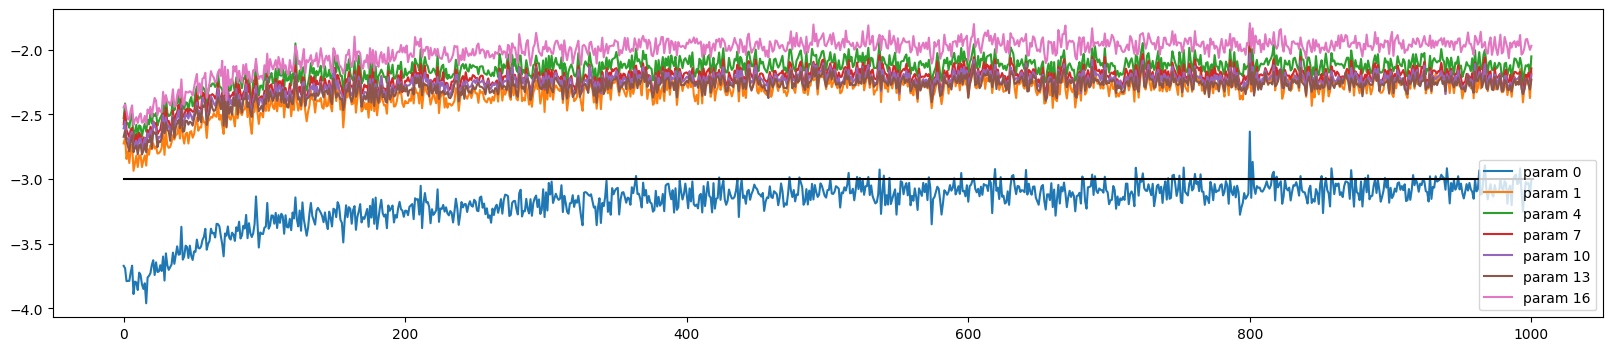

In [19]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [21]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_tr, Y_tr),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.354503631591797
val 2.569269895553589


In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) 

careah.
qabrilel.
kimrix.
taty.
halayane.
mahnen.
amerahci.
aqhi.
nelenia.
chaiiv.
kalein.
halm.
join.
qhinn.
salin.
alianbi.
wazelon.
jaryxi.
jameilinsa.
med.
